# Detecting harmuful corruption through model distillation.

### Method

Model distillation is a technique that is used to transfer knowledge from a large network to a smaller network. Tipically, it consists of training an ancillary model with a simplified architecture on soft targets (the output distributions or the logits) obtained from the original model. 

Here, we apply model distillation to obtain harmfullness scores, by comparining the output distributions of the original model with the output distributions 
of the distilled model, in order to detect adversarial data, malicious data drift or data corruption.
We use the following definition of harmfull and harmless data points:
* Harmfull data points are defined as inputs for which the model's predictions on the uncorrupted data are correct while the model's predictions on the corrupted data are wrong.
* Harmless data points are defined as inputs for which the model's predictions on the uncorrupted data are correct and the model's predictions on the corrupted data remain correct.

Analogously to the [adversarial detector](https://arxiv.org/abs/2002.09364), which is also part of the library, the model distillation detector picks up drift that reduces the performance of the classification model. 

Moreover, in this example a drift detector that applies two-sample [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (K-S) tests to the scores is employed. The p-values obtained are used to assess the harmufullness of the data. 

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance.

In [1]:
%set_env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tensorflow.keras.regularizers import l1
from alibi_detect.cd import KSDrift
from alibi_detect.ad import ModelDistillation

from alibi_detect.models.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.prediction import predict_batch
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

Importing plotly failed. Interactive plots will not work.


### Load data

Original CIFAR-10 data:

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)
X_train = scale_by_instance(X_train)
X_test = scale_by_instance(X_test)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [4]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [5]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the *H<sub>0</sub>* of the K-S test. We also split the corrupted data by corruption type:

In [6]:
X_c = []
n_corr = len(corruption)
n_test = X_test.shape[0]
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

We can visualise the same instance for each corruption type:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


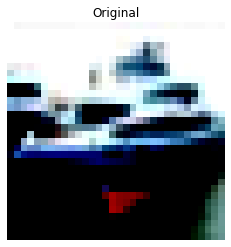

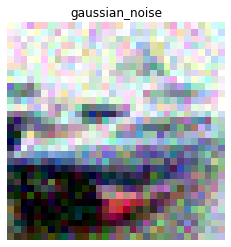

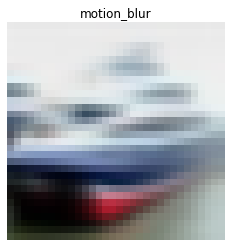

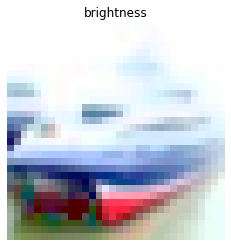

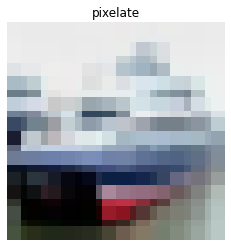

In [7]:
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [8]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


### Model distillation as a malicious drift detector

Analogously to the [adversarial detector](https://arxiv.org/abs/2002.09364), which uses an autoencoder to reproduce the output distribution of a classifier and produce adversarial scores, the model distillation detector achieves the same goal by using a simple classifier in place of the autoencoder. This approach is more flexible respect to the autoencoder approach since it bypasses the instance's generation step, and it can be applied in a straightforward way to a variety of data sets such as text or time series.

We can leverage the scores obtained trained on normal data and employ model distillation as a data drift detector. The score function of the detector becomes the preprocessing function for the drift detector. The K-S test is then a simple univariate test on the harmfullness scores. Importantly, an harmfullness detector flags **malicious data drift**. We can fetch the pretrained model distillation detector from a [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad/cifar10/resnet32) or train one from scratch:

Definition and distillation of the ancillary model

In [9]:
def ancilla_model_cifar10(clf,
                          nb_conv_layers=3,
                          nb_filters1=256,
                          nb_dense=40,
                          kernel1=4,
                          kernel2=4,
                          kernel3=4,
                          ae_arch=False):

    print('Define ancillary model')
    nb_filters1 = int(nb_filters1)
    nb_filters2 = int(nb_filters1 / 2)
    nb_filters3 = int(nb_filters1 / 4)
    layers = [InputLayer(input_shape=(32, 32, 3)),
              Conv2D(nb_filters1, kernel1, strides=2, padding='same')]
    if nb_conv_layers > 1:
        layers.append(Conv2D(nb_filters2, kernel2, strides=2, padding='same',
                             activation=tf.nn.relu, kernel_regularizer=l1(1e-5)))
    if nb_conv_layers > 2:
        layers.append(Conv2D(nb_filters3, kernel3, strides=2, padding='same',
                             activation=tf.nn.relu, kernel_regularizer=l1(1e-5)))
    layers.append(Flatten())
    layers.append(Dense(nb_dense))
    layers.append(Dense(clf.output_shape[1], activation='softmax'))
    ancillary_model = tf.keras.Sequential(layers)

    return ancillary_model


In [10]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]

In [11]:
load_pretrained = True

In [12]:
filepath = '/home/gio/.keras/datasets' # change to (absolute) directory where model is downloaded
if load_pretrained:
    detector_type = 'adversarial'
    detector_name = 'model_distillation'
    ad = fetch_detector(filepath, detector_type, dataset, detector_name, model=model)
    filepath = os.path.join(filepath, detector_name)
else:
    ancillary_model = ancilla_model_cifar10(clf)
    print(ancillary_model.summary())
    ad = ModelDistillation(distilled_model=ancillary_model, model=clf)
    ad.fit(X_train, epochs=50, batch_size=128, verbose=True)
    save_detector(ad, filepath)

Directory /home/gio/.keras/datasets/model_distillation does not exist and is now created.


2867200/2860312 [==============================] - 0s 0us/step


No threshold level set. Need to infer threshold using `infer_threshold`.


#### Scores and p-values calculation

Here we initialize the KS drift detector using the harmfullness scores as a preprocessing function. The KS test is performed on these scores. The following steps are implemented:

* We randomly pick `n_ref` samples from the non-currupted test set to be used as a reference set in the initialization of the K-S drift detector.  

* We split the corrupted data into harmfull and harmless data and visualize the harmfullness scores for various values of corruption severity.

* We sample batches of data of size `batch_size` contaminated with an increasing number of harmfull corrupted data and harmless corrupted data. 

* We apply the K-S test to these batches and obtain the p-values for each of them. The p-value represents the probability that the batch is sampled from the same probability distribution from which the reference set was sampled. 

* We observe that contamination of the batches with harmfull data reduces the p-values much faster than contamination with harmless data, in which cases the p-values remains above the detection treshold even when the batch is heavily contaminated.  

In [13]:
batch_size = 100
nb_batches = 100
severities = [1, 2, 3, 4, 5]

In [14]:
def sample_batch(x_orig, x_corr, batch_size, p):
    nb_orig = int(batch_size * (1 - p))
    nb_corr = batch_size - nb_orig
    perc = nb_corr / batch_size
    
    idx_orig = np.random.choice(range(x_orig.shape[0]), nb_orig)
    x_sample_orig = x_orig[idx_orig]    
    
    idx_corr = np.random.choice(range(x_corr.shape[0]), nb_corr)
    x_sample_corr = x_corr[idx_corr]
    
    x_batch = np.concatenate([x_sample_orig, x_sample_corr])
    return x_batch, perc

Initialise the drift detector:

In [15]:
np.random.seed(0)
n_ref = 1000
idx_ref = np.random.choice(range(X_test.shape[0]), n_ref)
X_ref = X_test[idx_ref]
labels = ['No!', 'Yes!']

cd = KSDrift(
    p_val=.05,
    X_ref=X_ref,
    preprocess_fn=ad.score,
    preprocess_kwargs={'batch_size': 128}
)

Calculate scores and p-values:

In [16]:
dfs = {}
score_drift = {
    1: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    2: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    3: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    4: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    5: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
}
y_pred = predict_batch(clf, X_test, batch_size=256, return_class=True)
score_x = ad.score(X_test, batch_size=256)

for s in severities:
    print('Loading corrupted data. Severity = {}'.format(s))
    X_corr, y_corr = fetch_cifar10c(corruption=corruptions, severity=s, return_X_y=True)
    print('Preprocess data...')
    X_corr = X_corr.astype('float32')
    X_corr = scale_by_instance(X_corr)
    
    print('Make predictions on corrupted dataset...')
    y_pred_corr = predict_batch(clf, X_corr, batch_size=1000, return_class=True)
    
    print('Compute adversarial scores on corrupted dataset...')
    score_corr = ad.score(X_corr, batch_size=256)
    
    labels_corr = np.zeros(score_corr.shape[0])
    repeat = y_corr.shape[0] // y_test.shape[0]
    y_pred_repeat = np.tile(y_pred, (repeat,))
    
    # malicious/harmful corruption: original prediction correct but
    # prediction on corrupted data incorrect
    idx_orig_right = np.where(y_pred_repeat == y_corr)[0]
    idx_corr_wrong = np.where(y_pred_corr != y_corr)[0]
    idx_harmful = np.intersect1d(idx_orig_right, idx_corr_wrong)
    
    # harmless corruption: original prediction correct and prediction
    # on corrupted data correct
    labels_corr[idx_harmful] = 1
    labels = np.concatenate([np.zeros(X_test.shape[0]), labels_corr]).astype(int)
    idx_corr_right = np.where(y_pred_corr == y_corr)[0]
    idx_harmless = np.intersect1d(idx_orig_right, idx_corr_right)
    
    # Split corrupted inputs in harmful and harmless
    X_corr_harm = X_corr[idx_harmful]
    X_corr_noharm = X_corr[idx_harmless]

    # Store adversarial scores for harmful and harmless data
    score_drift[s]['all'] = score_corr
    score_drift[s]['harm'] = score_corr[idx_harmful]
    score_drift[s]['noharm'] = score_corr[idx_harmless]
    score_drift[s]['acc'] = accuracy(y_corr, y_pred_corr)
    
    print('Compute p-values')
    for j in range(nb_batches):
        ps = []
        pvs_harm = []
        pvs_noharm = []
        for p in np.arange(0, 1, 0.1):
            # Sampling a batch of size `batch_size` where a fraction p of the data
            # is corrupted harmful data and a fraction 1 - p is non-corrupted data
            X_batch_harm, _ = sample_batch(X_test, X_corr_harm, batch_size, p)
            
            # Sampling a batch of size `batch_size` where a fraction p of the data
            # is corrupted harmless data and a fraction 1 - p is non-corrupted data
            X_batch_noharm, perc = sample_batch(X_test, X_corr_noharm, batch_size, p)
            
            # Calculating p-values for the harmful and harmless data by applying
            # K-S test on the adversarial scores
            pv_harm = cd.score(X_batch_harm)
            pv_noharm = cd.score(X_batch_noharm)
            ps.append(perc)
            pvs_harm.append(pv_harm[0])
            pvs_noharm.append(pv_noharm[0])
        if j == 0:
            df = pd.DataFrame({'p': ps})
        df['pvalue_harm_{}'.format(j)] = pvs_harm
        df['pvalue_noharm_{}'.format(j)] = pvs_noharm 

    for name in ['pvalue_harm', 'pvalue_noharm']:
        df[name + '_mean'] = df[[col for col in df.columns if name in col]].mean(axis=1)
        df[name + '_std'] = df[[col for col in df.columns if name in col]].std(axis=1)
        df[name + '_max'] = df[[col for col in df.columns if name in col]].max(axis=1)
        df[name + '_min'] = df[[col for col in df.columns if name in col]].min(axis=1)
    df.set_index('p', inplace=True)
    dfs[s] = df

Loading corrupted data. Severity = 1
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 2
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 3
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 4
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 5
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values


#### Plot scores

We now plot the mean scores and standard deviations per severity level. The plot shows the mean harmfullness scores (lhs) and ResNet-32 accuracies (rhs) for increasing data corruption severity levels. Level 0 corresponds to the original test set. Harmful scores  are scores from instances which have been flipped from the correct to an incorrect prediction because of the corruption. Not harmful means that a correct prediction was unchanged after the corruption.

In [17]:
mu_noharm, std_noharm = [], []
mu_harm, std_harm = [], []
acc = [clf_accuracy['original']]
for k, v in score_drift.items():
    mu_noharm.append(v['noharm'].mean())
    std_noharm.append(v['noharm'].std())
    mu_harm.append(v['harm'].mean())
    std_harm.append(v['harm'].std())
    acc.append(v['acc'])

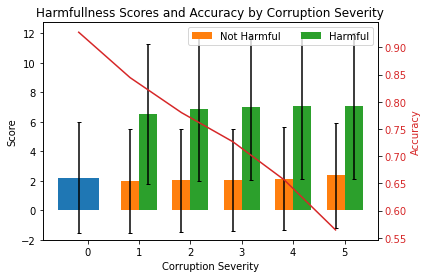

In [18]:
plot_labels = ['0', '1', '2', '3', '4', '5']

N = 6
ind = np.arange(N)
width = .35

fig_bar_cd, ax = plt.subplots()
ax2 = ax.twinx()

p0 = ax.bar(ind[0], score_x.mean(), yerr=score_x.std(), capsize=2)
p1 = ax.bar(ind[1:], mu_noharm, width, yerr=std_noharm, capsize=2)
p2 = ax.bar(ind[1:] + width, mu_harm, width, yerr=std_harm, capsize=2)

ax.set_title('Harmfullness Scores and Accuracy by Corruption Severity')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(plot_labels)
ax.set_ylim((-2))
ax.legend((p1[0], p2[0]), ('Not Harmful', 'Harmful'), loc='upper right', ncol=2)
ax.set_ylabel('Score')
ax.set_xlabel('Corruption Severity')

color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

#### Plot p-values for contaminated batches

In order to simulate a realistic scenario, we perform a K-S test on batches of instance which are increasingly contaminated with corrupted data. In this examples, each batch containes 100 instances where a fraction p consists of harmfull or harmless corrupted data. The instances are sampled randomly from the test set and the harmfull or harmless corrupted set. For each batch a K-S test is performed with respect to a reference set of 1000 instance sampled from the uncorrupted test set. The K-S test returns a p-values which represents the probability that the batch and the reference set are sampled from the same probability distribution. 

We repeat the test for 100 randomly sampled batches and we plot the mean and the maximum p-values for each level of severity and contamination below. We can see from the plot that the detector is able to cleary detect a batch contaminated with harmfull data with respect to a batch contaminated with harmless data when the contamination probability reaches 0.2-0.3.  

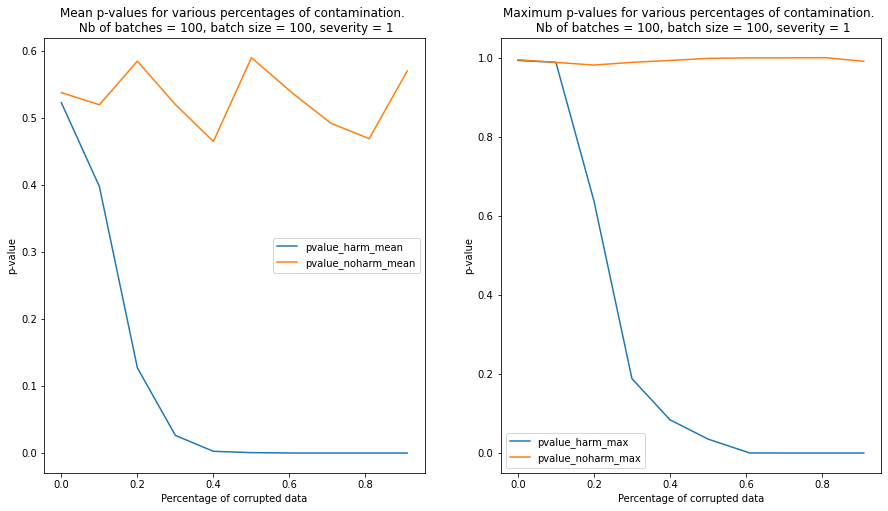

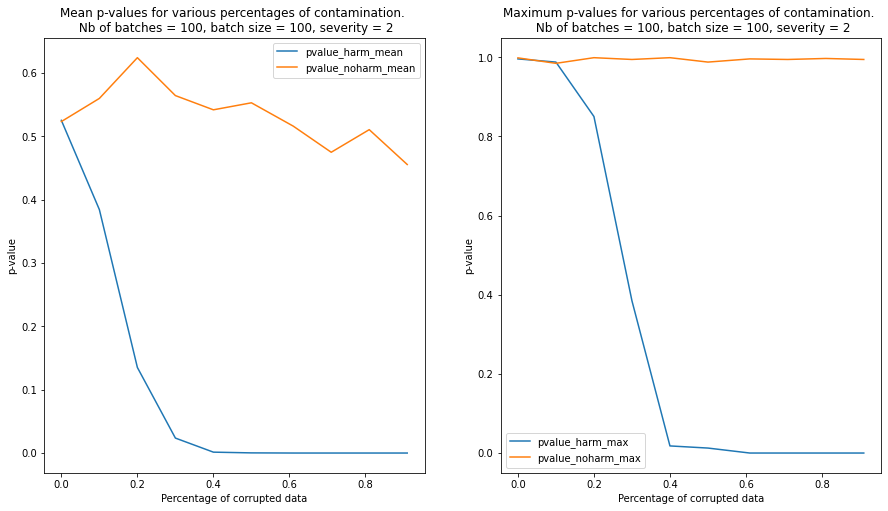

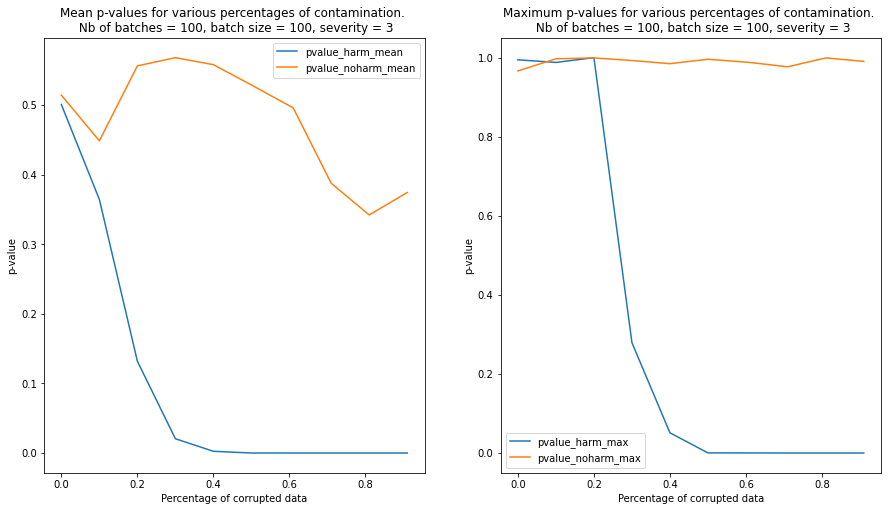

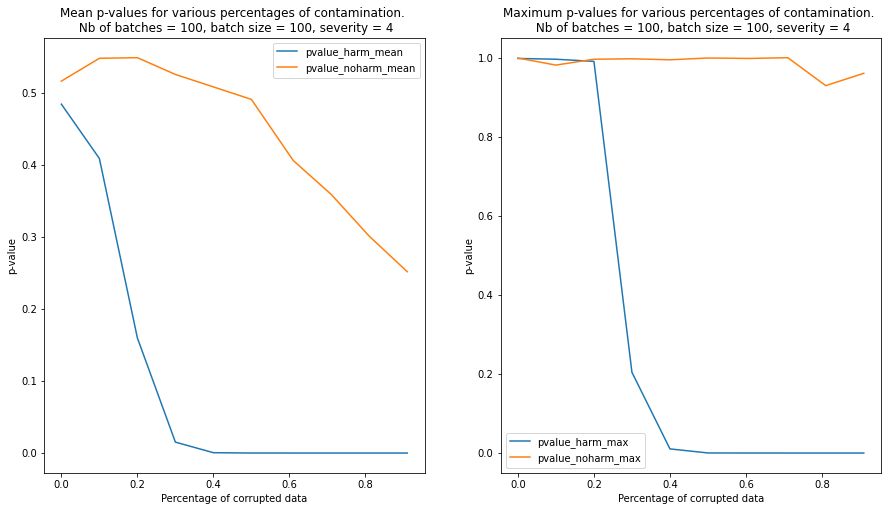

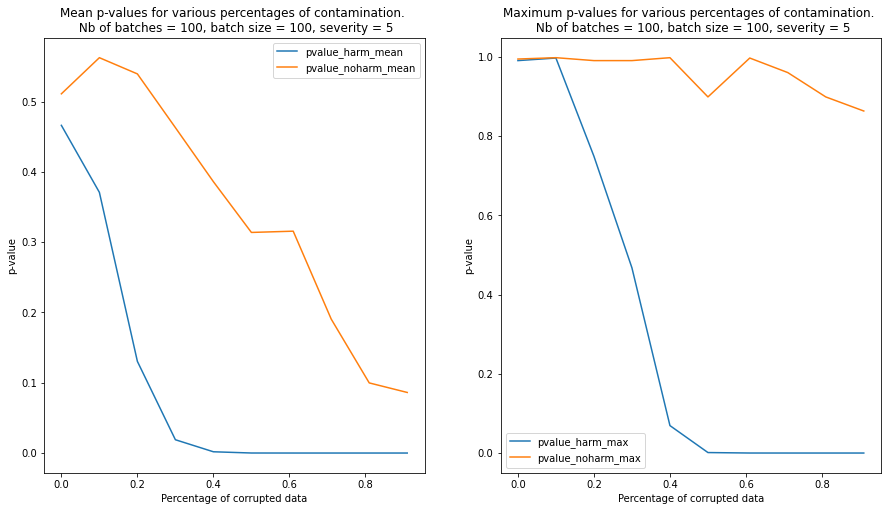

In [19]:
for s in severities:
    nrows = 1
    ncols = 2
    figsize = (15, 8)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    title0 = ('Mean p-values for various percentages of contamination. \n' 
             ' Nb of batches = {}, batch size = {}, severity = {}'.format(nb_batches, 
                                                                          batch_size, 
                                                                          s))
    title1 = ('Maximum p-values for various percentages of contamination. \n' 
             ' Nb of batches = {}, batch size = {}, severity = {}'.format(nb_batches, 
                                                                          batch_size, 
                                                                          s))
    dfs[s][['pvalue_harm_mean', 'pvalue_noharm_mean']].plot(ax=ax[0], 
                                                            title=title0)
    dfs[s][['pvalue_harm_max', 'pvalue_noharm_max']].plot(ax=ax[1], 
                                                          title=title1)
    for a in ax:
        a.set_xlabel('Percentage of corrupted data')
        a.set_ylabel('p-value')
